
# Comparison of kernel ridge and Gaussian process regression, LSTM


In [1]:
import os
import sys
import time

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline 

# Mackey-Glass data

In [2]:
cwd = os.getcwd()
cwd

'/data/TimeSeriesForcasting'

In [3]:
Y=np.load(os.path.join(cwd+'/data_timeseries/', 'y_mck.npy'))
Y.shape

(1000,)

In [4]:
X = np.linspace(0, 1000, num=1_000).reshape(-1, 1)

In [5]:
X.shape, Y.shape

((1000, 1), (1000,))

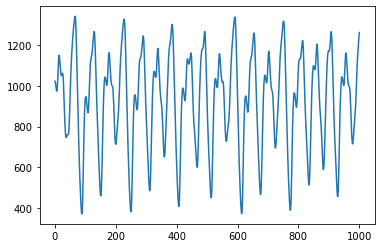

In [6]:
plt.plot(X,Y);

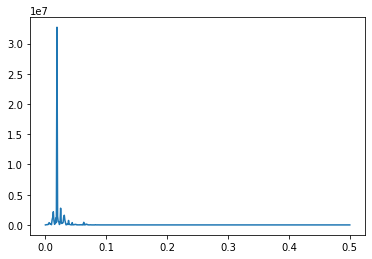

In [7]:
f, Pxx = signal.periodogram(Y)
plt.plot(f, Pxx);

In [8]:
top_3_periods = {}

# get indices for 3 highest Pxx values
top3_freq_indices = np.flip(np.argsort(Pxx), 0)[0:3]

# use indices from previous step to
# get 3 frequencies with highest power
freqs = f[top3_freq_indices]

# use same indices to get powers as well
power = Pxx[top3_freq_indices]

# we are interested in period and it is calculated as 1/frequency 
periods = 1 / np.array(freqs)

# populate dict with calculated values
top_3_periods['period1'] = periods[0]
top_3_periods['freq1'] = freqs[0]
top_3_periods['power1'] = power[0]

top_3_periods['period2'] = periods[1]
top_3_periods['freq2'] = freqs[1]
top_3_periods['power2'] = power[1]

top_3_periods['period3'] = periods[2]
top_3_periods['freq3'] = freqs[2]
top_3_periods['power3'] = power[2]

In [9]:
top_3_periods

{'period1': 52.631578947368425,
 'freq1': 0.019,
 'power1': 32693230.0,
 'period2': 40.0,
 'freq2': 0.025,
 'power2': 2767071.8,
 'period3': 76.92307692307692,
 'freq3': 0.013000000000000001,
 'power3': 2175414.8}

In [10]:
training_sample_indices = np.arange(0, 600)

In [11]:
rng = np.random.RandomState(0)

In [12]:
training_X = X[training_sample_indices]
training_Y = Y[training_sample_indices] + 0.5 * rng.randn(len(training_sample_indices))

In [13]:
training_X.shape, training_Y.shape

((600, 1), (600,))

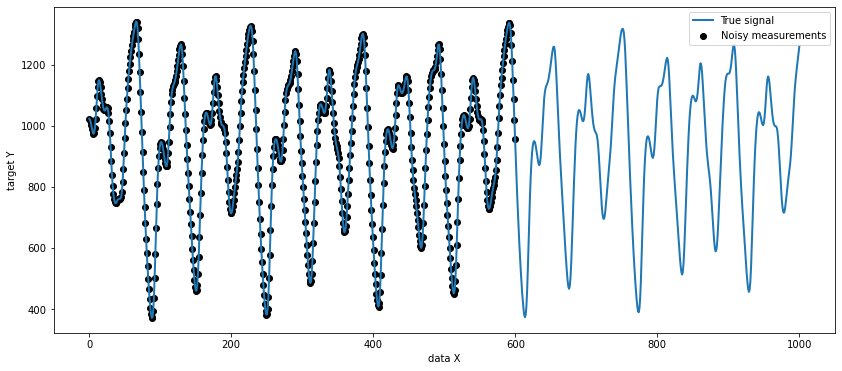

In [14]:
fig = plt.figure(figsize=(14,6))
plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
plt.legend()
plt.xlabel("data X")
plt.ylabel("target Y")
plt.show()

## Limitations of a simple linear model

First, we would like to highlight the limitations of a linear model given
our dataset. We fit a :class:`~sklearn.linear_model.Ridge` and check the
predictions of this model on our dataset.



In [15]:
from sklearn.linear_model import Ridge

In [16]:
ridge = Ridge().fit(training_X, training_Y)

In [17]:
Y_predicted_ridge=ridge.predict(X)

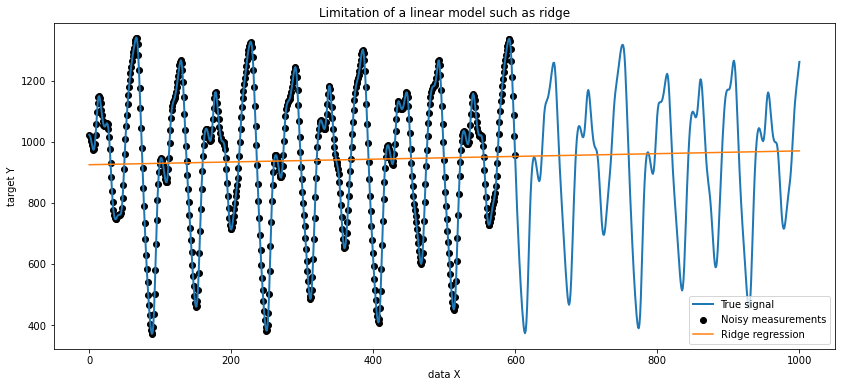

In [18]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)

plt.plot(X, Y_predicted_ridge, label="Ridge regression")
plt.legend()
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title("Limitation of a linear model such as ridge")
plt.show()

Such a ridge regressor underfits data since it is not expressive enough.

## Kernel methods: kernel ridge and Gaussian process

### Kernel ridge



In [19]:
import time
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

kernel_ridge = KernelRidge(kernel=ExpSineSquared())

In [20]:
start_time = time.time()
kernel_ridge.fit(training_X, training_Y)
print(f"Fitting KernelRidge with default kernel: {time.time() - start_time:.3f} seconds")

Fitting KernelRidge with default kernel: 0.065 seconds


In [21]:
Y_predicted_kr=kernel_ridge.predict(X)

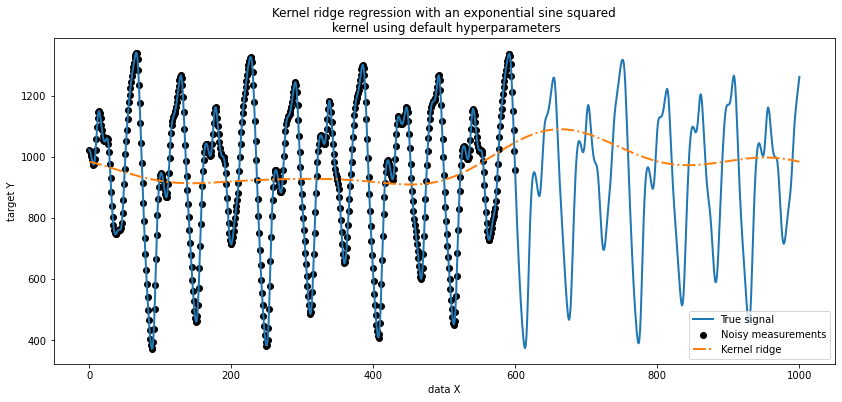

In [22]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
plt.plot(X, Y_predicted_kr,label="Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using default hyperparameters")
plt.show()

This fitted model is not accurate. Indeed, we did not set the parameters of
the kernel and instead used the default ones. We can inspect them.



In [23]:
kernel_ridge.kernel

ExpSineSquared(length_scale=1, periodicity=1)

Our kernel has two parameters: the length-scale and the periodicity. For our
dataset, we use `sin` as the generative process, implying a
$2 \pi$-periodicity for the signal. The default value of the parameter
being $1$, it explains the high frequency observed in the predictions of
our model.
Similar conclusions could be drawn with the length-scale parameter. Thus, it
tell us that the kernel parameters need to be tuned. We will use a randomized
search to tune the different parameters the kernel ridge model: the `alpha`
parameter and the kernel parameters.



In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}

kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=1000,
    random_state=0,
)

In [25]:
start_time = time.time()
kernel_ridge_tuned.fit(training_X, training_Y)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

Time for KernelRidge fitting: 362.743 seconds


Fitting the model is now more computationally expensive since we have to try
several combinations of hyperparameters. We can have a look at the
hyperparameters found to get some intuitions.



In [26]:
kernel_ridge_tuned.best_params_

{'alpha': 2.5265093758227777,
 'kernel__length_scale': 0.1845714329011255,
 'kernel__periodicity': 1.989529169089363}

Looking at the best parameters, we see that they are different from the
defaults. We also see that the periodicity is closer to the expected value:
$2 \pi$. We can now inspect the predictions of our tuned kernel ridge.



In [27]:
start_time = time.time()
Y_predicted_kr_opt = kernel_ridge_tuned.predict(X)
print(f"Time for KernelRidge predict: {time.time() - start_time:.3f} seconds")

Time for KernelRidge predict: 0.058 seconds


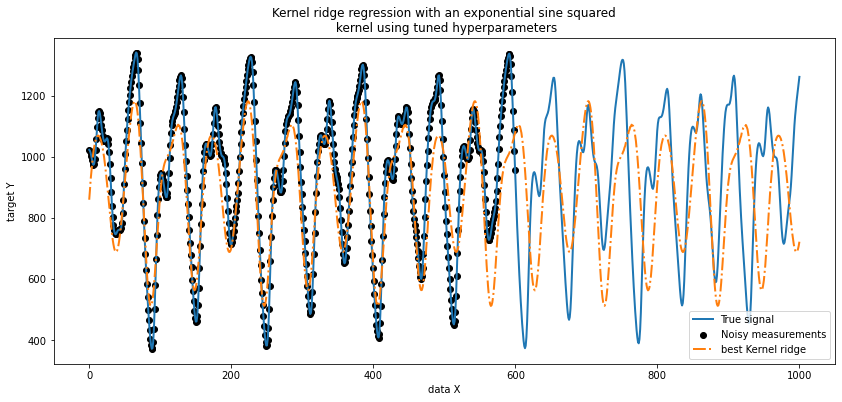

In [28]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title(
    "Kernel ridge regression with an exponential sine squared\n "
    "kernel using tuned hyperparameters")
plt.show()

We get a much more accurate model. We still observe some errors mainly due to
the noise added to the dataset.

### Gaussian process regression

Now, we will use a
:class:`~sklearn.gaussian_process.GaussianProcessRegressor` to fit the same
dataset. When training a Gaussian process, the hyperparameters of the kernel
are optimized during the fitting process. There is no need for an external
hyperparameter search. Here, we create a slightly more complex kernel than
for the kernel ridge regressor: we add a
:class:`~sklearn.gaussian_process.kernels.WhiteKernel` that is used to
estimate the noise in the dataset.



In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel

kernel = 10.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e10)) + WhiteKernel(1e-1)
gaussian_process = GaussianProcessRegressor(kernel=kernel)

In [30]:
kernel(X).shape

(1000, 1000)

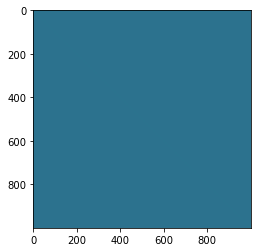

In [31]:
plt.imshow(kernel(X));
plt.show()

In [32]:
start_time = time.time()

gaussian_process.fit(training_X, training_Y)
print(f"Time for GaussianProcessRegressor fitting: {time.time() - start_time:.3f} seconds")

Time for GaussianProcessRegressor fitting: 0.239 seconds


/home/meysam/anaconda3/envs/ts_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/meysam/anaconda3/envs/ts_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/meysam/anaconda3/envs/ts_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__periodicity is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning

The computation cost of training a Gaussian process is much less than the
kernel ridge that uses a randomized search. We can check the parameters of
the kernels that we computed.



In [33]:
gaussian_process.kernel_

316**2 * ExpSineSquared(length_scale=1e-05, periodicity=0.01) + WhiteKernel(noise_level=1e+05)

Indeed, we see that the parameters have been optimized. Looking at the
`periodicity` parameter, we see that we found a period close to the
theoretical value $2 \pi$. We can have a look now at the predictions of
our model.



In [34]:
start_time = time.time()
Y_mean_predictions_gpr, Y_std_predictions_gpr = gaussian_process.predict(X,return_std=True,)
print(f"Time for GaussianProcessRegressor predict: {time.time() - start_time:.3f} seconds")

Time for GaussianProcessRegressor predict: 0.068 seconds


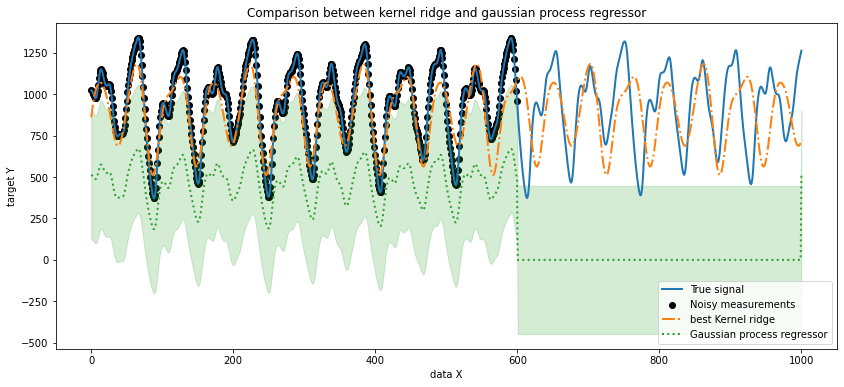

In [35]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
# Plot the predictions of the kernel ridge
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
# Plot the predictions of the gaussian process regressor
plt.plot(X,Y_mean_predictions_gpr,label="Gaussian process regressor",linewidth=2,linestyle="dotted",)
plt.fill_between(X.ravel(),
                 Y_mean_predictions_gpr - Y_std_predictions_gpr,
                 Y_mean_predictions_gpr + Y_std_predictions_gpr,
                 color="tab:green", alpha=0.2,)
plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title("Comparison between kernel ridge and gaussian process regressor")

plt.show()

We observe that the results of the kernel ridge and the Gaussian process
regressor are close. However, the Gaussian process regressor also provide
an uncertainty information that is not available with a kernel ridge.
Due to the probabilistic formulation of the target functions, the
Gaussian process can output the standard deviation (or the covariance)
together with the mean predictions of the target functions.

However, it comes at a cost: the time to compute the predictions is higher
with a Gaussian process.


We can give a final word regarding the possibility of the two models to
extrapolate. Indeed, we only provided the beginning of the signal as a
training set. Using a periodic kernel forces our model to repeat the pattern
found on the training set. Using this kernel information together with the
capacity of the both models to extrapolate, we observe that the models will
continue to predict the sine pattern.

Gaussian process allows to combine kernels together. Thus, we could associate
the exponential sine squared kernel together with a radial basis function
kernel.



In [36]:
from sklearn.gaussian_process.kernels import RBF

kernel = 1.0 * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) * RBF(
    length_scale=15, length_scale_bounds="fixed") + WhiteKernel(1e-1)

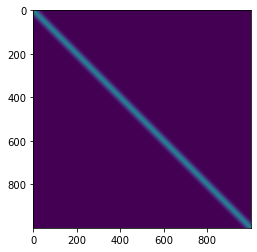

In [37]:
plt.imshow(kernel(X));
plt.show()

In [38]:
gaussian_process = GaussianProcessRegressor(kernel=kernel)
gaussian_process.fit(training_X, training_Y)

Y_mean_predictions_gpr, Y_std_predictions_gpr = gaussian_process.predict(X,return_std=True,)

/home/meysam/anaconda3/envs/ts_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/meysam/anaconda3/envs/ts_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


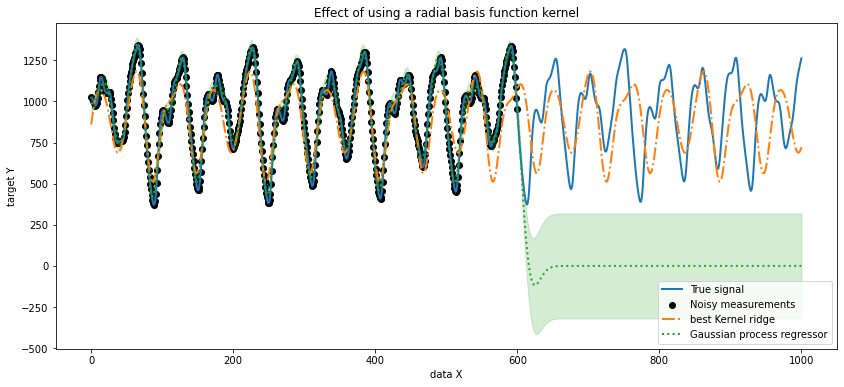

In [39]:
fig = plt.figure(figsize=(14,6))

plt.plot(X, Y, label="True signal", linewidth=2)
plt.scatter(training_X,training_Y,color="black", label="Noisy measurements",)
# Plot the predictions of the kernel ridge
plt.plot(X,Y_predicted_kr_opt,label="best Kernel ridge",linewidth=2,linestyle="dashdot",)
# Plot the predictions of the gaussian process regressor
plt.plot(X,Y_mean_predictions_gpr,label="Gaussian process regressor",linewidth=2,linestyle="dotted",)
plt.fill_between(X.ravel(),
                 Y_mean_predictions_gpr - Y_std_predictions_gpr,
                 Y_mean_predictions_gpr + Y_std_predictions_gpr,
                color="tab:green", alpha=0.2,)
plt.legend(loc="lower right")
plt.xlabel("data X")
plt.ylabel("target Y")
_ = plt.title("Effect of using a radial basis function kernel")
plt.show()

The effect of using a radial basis function kernel will attenuate the
periodicity effect once that no sample are available in the training.
As testing samples get further away from the training ones, predictions
are converging towards their mean and their standard deviation
also increases.

